In [12]:
import random
import numpy as np
from statistics import mean
from random import randrange
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
class KNearestKneighbors():
    def __init__(self, k, p):
        self.k = k
        self.p = p

    def train(self, X, y):
        self.X_train = self.min_max_scaler(X)
        self.y_train = y

    def predict(self, X_test):
        X_test_normed = self.min_max_scaler(X_test)
        distances = self.compute_distance(X_test_normed)
        return self.predict_labels(distances)

#     def compute_distance(self, X_test):
#         distances = np.sqrt(np.sum(X_test**2, axis=1, keepdims=True) + np.sum(self.X_train**2, axis=1, keepdims=True).T - 2*np.dot(X_test, self.X_train.T))
#         return distances

    def compute_distance(self, X_test):
        num_test = X_test.shape[0]
        num_train = self.X_train.shape[0]
        distances = np.zeros((num_test, num_train))
        
        for i in range(num_test):
            for j in range(num_train):
                distances[i, j] = np.sum(np.absolute(X_test[i,:] - self.X_train[j,:])**self.p)**(self.p**-1)
#         distances = self.minkowski_distance(self.X_train[None, :, :], X_test[:, None, :]).T
        return distances
#     def minkowski_distance(self, arr1, arr2):
#         return np.sum(np.absolute(arr1 - arr2)**self.p)**(self.p**-1)
    
    def min_max_scaler(self, data):
        return np.where(data.ptp(0) == 0, data, (data - data.min(0)) / data.ptp(0))
#     def nonzero_one_scaler(self, data):
#         return np.where(data == 0, data, 1)
    
    def predict_labels(self, distances):
        n_test = distances.shape[0]
        y_pred = np.zeros(n_test)

        for i in range(n_test):
            y_index = np.argsort(distances[i, :])
            k_closests = self.y_train[y_index[:self.k]].astype(int)
            y_pred[i] = np.argmax(np.bincount(k_closests))
        return y_pred

In [14]:
def cross_validation_split(data, folds=5):
    k_sets = []
    data_copy = data
    fold_size = int(data.shape[0] / folds)
    for _ in range(folds):
        fold = []
        while len(fold) < fold_size:
            dummy = randrange(data.shape[0])
            fold.append(data_copy[dummy])
            np.delete(data_copy, dummy)
        k_sets.append(np.asarray(fold))
    return k_sets

In [15]:
def cross_val_score(dataset, cv=5, k=5, p=2):
    data = cross_validation_split(dataset, cv)
    result = []
    for i in range(cv):
        level = list(range(cv))
        level.pop(i)
        for j in level:
            if j == level[0]:
                folds = data[j]
            else:    
                folds = np.concatenate((folds, data[j]), axis=0)
        KNN = KNearestKneighbors(k=k, p=p)
        KNN.train(folds[:,1:], folds[:,0])
        y_pred = KNN.predict(data[i][:,1:])
        acc = (y_pred == data[i][:,0]).sum()
        result.append(acc / y_pred.shape[0])
    return result

In [16]:
train_small = np.genfromtxt(
        'datasets/MNIST_train_small.csv', delimiter=',')
test_small = np.genfromtxt('datasets/MNIST_test_small.csv', delimiter=',')

In [17]:
KNN = KNearestKneighbors(3, 3)
KNN.train(train_small[:,1:], train_small[:,0])
y_pred = KNN.predict(test_small[:,1:])
print(f"Accuracy: {sum(y_pred==test_small[:,0])/test_small[:,0].shape[0]}")

D:\Applications\Anaconda3\envs\ds\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


Accuracy: 0.924


D:\Applications\Anaconda3\envs\ds\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


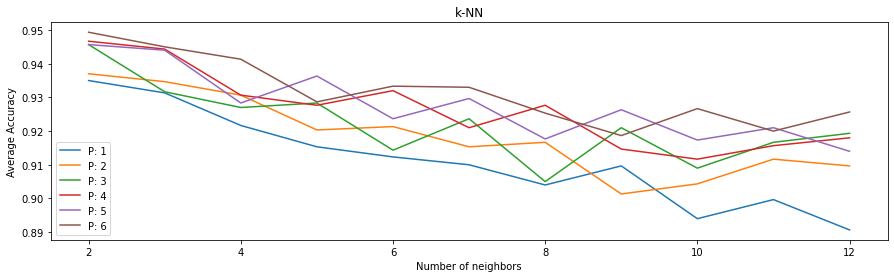

In [18]:
random.seed(1)
# plot the change in the average accuracy according to k
plt.figure(figsize = (15, 4))
plt.title("k-NN")
plt.xlabel("Number of neighbors")
plt.ylabel("Average Accuracy")
for p in range(1, 7):
    knn = []
    for k in range(2, 13):
        # k-fold cv from scratch for k-NN
        acc = mean(cross_val_score(train_small, cv=12, k=k, p=p))
        knn.append(acc)
    plt.plot(range(2, 13), knn, label=f'P: {p}')
plt.legend()
plt.show()
#         print(f'Accuracy: {acc:.3f}, K: {k}, P: {p}')
# plt.figure(figsize = (15, 4))
# plt.title("k-NN")
# plt.xlabel("Number of neighbors")
# plt.ylabel("Average Accuracy")
# plt.plot(range(2, 13), knn);